<h1 style="text-align: center;">Assignment 2</h1>



In [1]:
################## imports  ####################################
import urllib.request
import pandas as pd
import json
import os
import networkx as nx
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import nltk
import os
from tqdm.notebook import tqdm
import json
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
from matplotlib.lines import Line2D
import ast

import warnings
warnings.filterwarnings("ignore")

# in order to include specific numbers in our reasoning
np.random.seed(7)

###############################################################

#################### Functions ################################

def flatten_and_remove_empty(l):
    return [item for sublist in l for item in sublist if item != '']

def check_if_present_in_links(dc_df, marvel_df, link):
    target = dc_df.loc[dc_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    target = marvel_df.loc[marvel_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    return None

def check_if_present_in_names(dc_df, marvel_df, name):
    target = dc_df.loc[dc_df['CharacterName'] == name]
    if not target.empty:
        return name
    target = marvel_df.loc[marvel_df['CharacterName'] == name]
    if not target.empty:
        return name
    
    return None
    
def get_name_from_link(df, link):
    target = df.loc[df['WikiLink'] == link]
    return target['CharacterName']
    
def get_charactername_from_filename(filename):
    return filename.replace("_*_"," ").replace("-*-","/").replace(".txt","")

def get_filename_from_charactername(character_name):
    return character_name.replace(" ", "_*_").replace("/","-*-")

###############################################################

################### Global Definitions ########################
dc_unv = "DC"
marvel_unv = "Marvel"
universes = [dc_unv, marvel_unv]
data_folder = "../Data/"
###############################################################

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Data

This assignment will be based on the DC and Marvel superhero dataset you downloaded during the Week 4 exercises. It's important that you work with your own dataset.

You will need the network structure and the page texts to complete the assignment.

To show that you have collected these files, please place your files somewhere that's accessible online (e.g. a github repo or a webpage) and link to your files from your notebook. (We will appreciate it if you store the wiki pages in plain text and the network as an edgelist. )

In [2]:
# Load Graph
DC_Marvel_Graph = nx.read_gpickle("../Data/graph.gpickle")

# Load Wikipages as a dictionary with key the CharacterName and value the text of the wikipage
with open('../Data/wikipages.txt') as f:
    data = f.read()
    
wikipages_text = ast.literal_eval(data)
  

# Basic Stats

Write a short paragraph describing the network. The paragraph should contain the following information

* The number of nodes and links. 
* The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

We also want the degree distributions and a plot of the network

* Create in- and out-going degree distributions as described in Lecture 5.
* Estimate the slope of the incoming degree distribtion as described in Lecture 5.
* Plot the network using the Force Atlas algorithm as described in Lecture 5.

(Friendly hint: Remember figure captions.)

In [3]:
def print_statistics(my_graph, name):
    
    in_degrees = np.array([val for node,val in list(my_graph.in_degree())])
    out_degrees = np.array([val for node,val in list(my_graph.out_degree())])
    
    print(f"\nDegree Statistics of the {name}.")
    print("\tIn-Degree Statistics:")
    mode = stats.mode(in_degrees, axis=None, keepdims=False)
    print(f"\t\tAverage = {np.mean(in_degrees):.2f} \n\t\tMedian = {np.median(in_degrees):.2f}\
                            \n\t\tMode={mode[0]} with {mode[1]} occurences\
                            \n\t\tMinimum = {np.min(in_degrees):.2f}\n\t\tMaximum = {np.max(in_degrees):.2f}.")
    print("\n\tOut-Degree Statistics:")
    
    mode = stats.mode(out_degrees, axis=None, keepdims=False)
    print(f"\t\tAverage = {np.mean(out_degrees):.2f}\n\t\tMedian = {np.median(out_degrees):.2f},\
                            \n\t\tMode={mode[0]} with {mode[1]} occurences\
                            \n\t\tMinimum = {np.min(out_degrees):.2f}\n\t\tMaximum = {np.max(out_degrees):.2f}.")

    

print(f"Number of nodes: {DC_Marvel_Graph.number_of_nodes()}")
print(f"Number of edges: {DC_Marvel_Graph.number_of_edges()}")

in_degrees = sorted(list(DC_Marvel_Graph.in_degree()),key=lambda d: d[1], reverse=True)
out_degrees = sorted(list(DC_Marvel_Graph.out_degree()),key=lambda d: d[1], reverse=True)

in_only_degrees = [val for node,val in in_degrees]
out_only_degrees = [val for node,val in out_degrees]


in_degrees_np = np.array(in_only_degrees)
out_degrees_np = np.array(out_only_degrees)

# DC_nodes = (
#     node
#     for node, data
#     in DC_Marvel_Graph.nodes(data=True)
#     if data.get("universe") == "DC"
# )
# DC_subgraph = DC_Marvel_Graph.subgraph(DC_nodes)

# Marvel_nodes = (
#     node
#     for node, data
#     in DC_Marvel_Graph.nodes(data=True)
#     if data.get("universe") == "Marvel"
# )
# Marvel_subgraph = DC_Marvel_Graph.subgraph(Marvel_nodes)


print_statistics(DC_Marvel_Graph, "DC - Marvel Network")

# print_statistics(DC_subgraph, "DC Network")

# print_statistics(Marvel_subgraph, "Marvel Network")


Number of nodes: 2276
Number of edges: 30869

Degree Statistics of the DC - Marvel Network.
	In-Degree Statistics:
		Average = 13.56 
		Median = 5.00                            
		Mode=0 with 396 occurences                            
		Minimum = 0.00
		Maximum = 467.00.

	Out-Degree Statistics:
		Average = 13.56
		Median = 9.00,                            
		Mode=0 with 593 occurences                            
		Minimum = 0.00
		Maximum = 128.00.


So our network consists of 2276 nodes and 30689 edges and the average degree of each node is 13.5.

About the incoming degree statistics, we can see that even though the average degree is 13.5 the median is only 5 whereas the maximum value is 467. This is an indication that the strong majority of the characters have very few incoming references while there are some very popular characters-hubs that  outperform all the others in terms of incoming references. We can also observe that there are 396 characters with no incoming references.

Regarding the outgoing degree statistics our first observation is the 593 nodes with 0 outgoing references. This may has to do with the construction of the network where we did not check for re-directs in the absence of a page. The mean value is 9.00 and the maximum value is 128. It is expected to have a much lower maximum degree than in the incoming degree since a page may be referenced infinite other pages but an individual page cannot include infinite referencdes because of the size limitation. Furthermore, the distribution again is not balanced since have of the nodes have less or equal to 9 outgoing references whereas the maximum degree is 128.

We will explore more about the degree distributions afterwards.

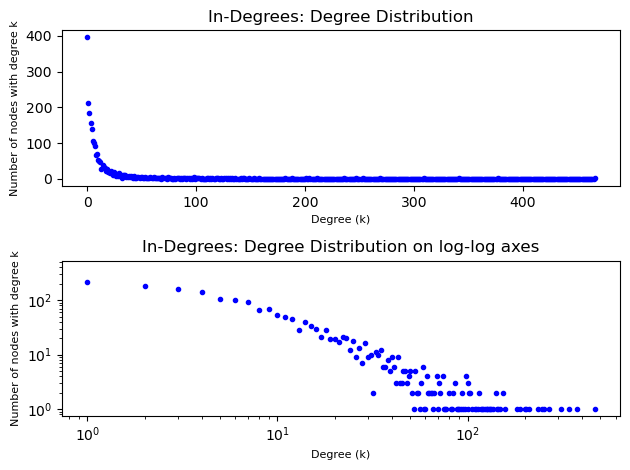

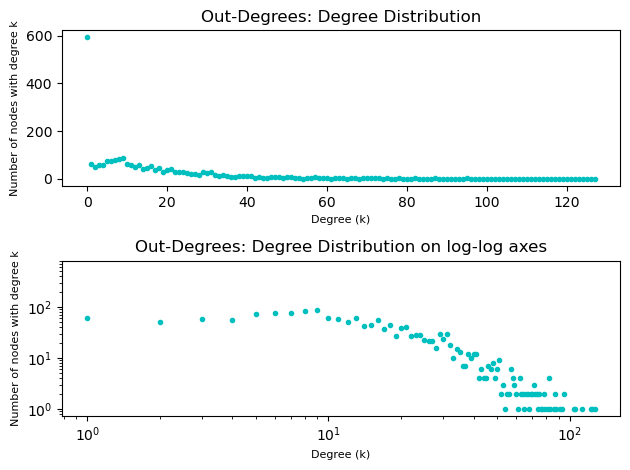

In [4]:
def plot_degree_distribution(degrees, title, color):
    counts, limits = np.histogram(degrees, degrees[0])

    x = limits[:len(counts)]
    y = counts

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(x, y, color)
    ax1.set_title(title)
    ax1.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax1.set_xlabel('Degree (k)',fontsize=8)

    ax2 =plt.subplot(2, 1, 2)
    ax2.loglog(x, y, color)
    ax2.set_title(title + ' on log-log axes')
    ax2.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax2.set_xlabel('Degree (k)',fontsize=8 )

    plt.tight_layout()
    plt.show()
    
    

plot_degree_distribution(in_only_degrees, "In-Degrees: Degree Distribution", 'b.')

plot_degree_distribution(out_only_degrees, "Out-Degrees: Degree Distribution", 'c.')

In [5]:
import powerlaw 

in_degrees = np.array([val for node,val in list(DC_Marvel_Graph.in_degree())])
out_degrees = np.array([val for node,val in list(DC_Marvel_Graph.out_degree())])
    
fit = powerlaw.Fit(in_degrees)

print(f"In Degrees slope = {fit.alpha:.2f}")

fit = powerlaw.Fit(out_degrees)

print(f"Out degrees slope = {fit.alpha:.2f}")

Calculating best minimal value for power law fit
In Degrees slope = 2.54
Calculating best minimal value for power law fit
Out degrees slope = 3.48


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [6]:
maxcc = max(nx.weakly_connected_components(DC_Marvel_Graph), key=len)

GCC = DC_Marvel_Graph.subgraph(maxcc)

print("Number of Nodes of Largest Connected Component = {}".format(GCC.number_of_nodes()))
print("Number of Edges of Largest Connected Component = {}".format(GCC.number_of_edges()))

Number of Nodes of Largest Connected Component = 2090
Number of Edges of Largest Connected Component = 30866


Number of edges after converting to undirected = 26800


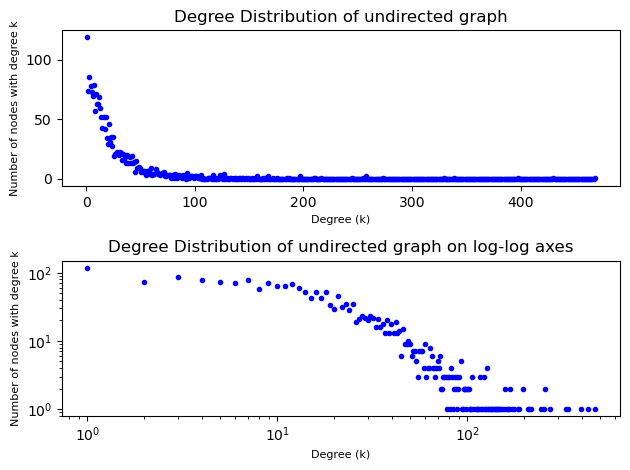

In [7]:
GCC_undirected = GCC.to_undirected()

print("Number of edges after converting to undirected = {}".format(GCC_undirected.number_of_edges()))


#Degree Distribution

degrees = sorted(list(GCC_undirected.degree()),key=lambda d: d[1], reverse=True)

degrees_only = [val for node,val in degrees]


plot_degree_distribution(degrees_only, "Degree Distribution of undirected graph", 'b.')

100%|██████████| 2000/2000 [01:06<00:00, 29.95it/s]


BarnesHut Approximation  took  16.01  seconds
Repulsion forces  took  47.91  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.66  seconds
AdjustSpeedAndApplyForces step  took  0.88  seconds


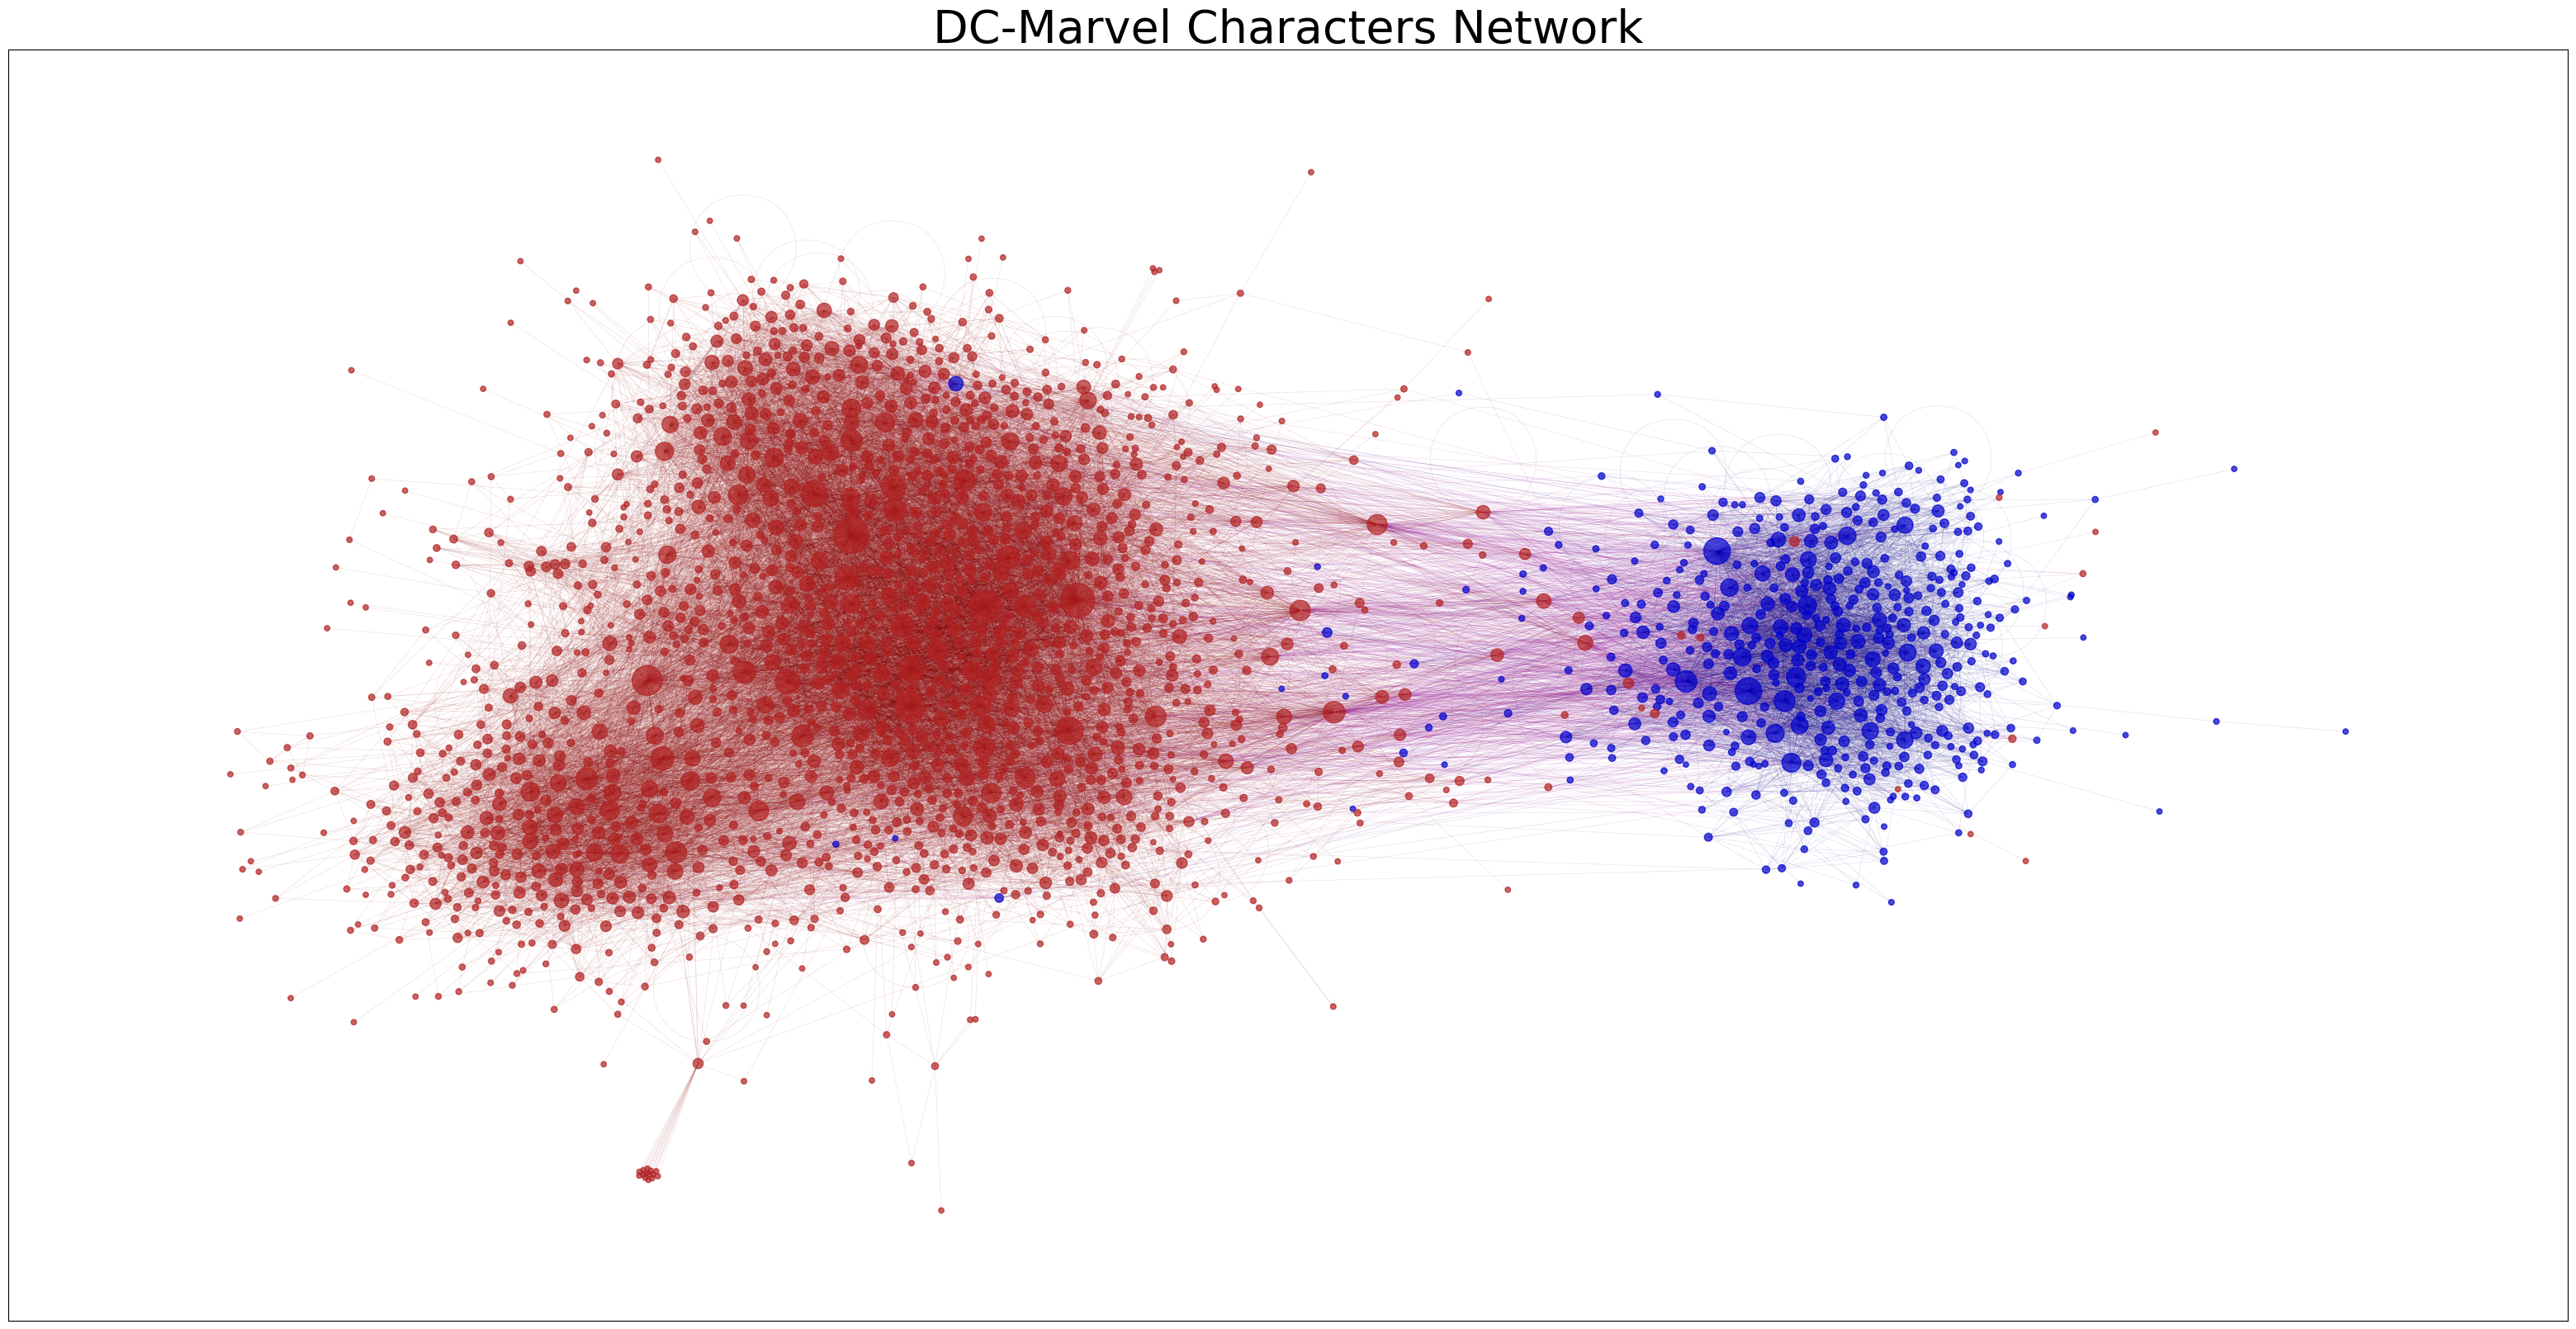

In [8]:
from fa2 import ForceAtlas2

node_sizes = [val*2+20 for node, val in GCC_undirected.degree()]
node_colors = ['#0000CD' if node[1]['universe'] == "DC" else '#B22222' for node in GCC_undirected.nodes(data=True)]
edge_colors = ['#000080' if GCC_undirected.nodes[node1]['universe'] == GCC_undirected.nodes[node2]['universe'] == "DC"\
               else '#8B0000' if GCC_undirected.nodes[node1]['universe'] == GCC_undirected.nodes[node2]['universe'] == "Marvel" \
               else '#8B008B' for node1,node2 in GCC_undirected.edges]

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=-1,

                        # Log
                        verbose=True)

# plt.figure(figsize=(25,25))
# ax = plt.gca()
# ax.set_title('DC-Marvel Characters Network',fontsize = 40) 
args = {
'node_color': node_colors,
'edge_color':edge_colors,
'node_size':node_sizes,
'width':0.3,
'linewidths':0.3,
}

figure = plt.figure(figsize=(40,20))
# plt.savefig(figure, dpi=1200)
ax = plt.gca()
ax.set_title('DC-Marvel Characters Network',fontsize = 40) 

positions = forceatlas2.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)
#nx.draw(GCC_undirected,positions, **args, ax=ax)

nx.draw_networkx_nodes(
    G = GCC_undirected,
    node_size = node_sizes,
    pos = positions, 
    node_color = node_colors,
    alpha = 0.7
)
nx.draw_networkx_edges(
    G = GCC_undirected,
    pos = positions, 
    edge_color = edge_colors, 
    alpha = 0.2,
    width = 0.3
    #linewidths=0.3
)

plt.show()

# Communities

Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

# Sentiment

First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

Now grab the good/bad character names ([from this file](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/b1668fe5fbea0765ed6f9cf896bfaf208a13765b/files/wiki_meta_data.csv), see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.

Finally use the label permutation test (see Week 5) to investigate the two hypotheses below
* H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

Write a short paragraph reflecting on your findings.

In [9]:
def calculate_sentiment(tokens_list):
    freq = nltk.FreqDist(w for w in tokens_list if w in labmit1_dictionary.keys())
    freq_count = sum(list(freq.values())) 
    sentiment_count = sum(labmit1_dictionary[w]*freq[w] for w in freq.keys())
    if(freq_count != 0):
        return sentiment_count/freq_count
    else:
        return -1


labmit1 = pd.read_table("../Data/labMIT-1.0.txt")

#create a dictionary with key the word and value the happinesss average
labmit1_dictionary = dict(zip(labmit1["word"], labmit1["happiness_average"]))

#remove words with sentiment from 4 to 6 
labmit1_dictionary = {word: sentiment for word, sentiment 
                                in labmit1_dictionary.items() 
                                if sentiment <= 4.5 or sentiment >= 5.5}

#create a dictionary with the tokenized lower text as value and key characterName
tokens = dict()

#remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

for item in wikipages_text.items():    
    tokens[item[0]] = tokenizer.tokenize(item[1].lower())
    
    
#calculate sentiment per character
sentiment_per_character = dict(zip(tokens.keys(), map(calculate_sentiment,tokens.values())))

#remove characters that in their pages no word was found
sentiment_per_character = {key:value for key,value in sentiment_per_character.items() if value > -1}

The labMT 1.0.txt file containing the happiness rating for 10,222 words was obtained from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752. In short it was constructed as follows:

For the word list, they consulted three sources. Twitter, English-language Google Books, 1960-2007 music lyrics, and the New York Times (1987-2007). They created word lists for each corpus that were arranged according to decreasing frequency of occurrence, then combined the top 5,000 words from each source to create a composite collection of 10,222 unique words.


They obtained 50 independent evaluations for each word by asking Mechanical Turk users to judge how a word made them feel on a nine-point integer scale. They divided the larger assignment into 100 smaller jobs, each requiring the evaluation of roughly 100 randomly chosen words. They highlighted the numbers 1, 3, 5, 7, and 9 using stylised expressions that ranged from unhappy to pleased.

In the paper they also describe that after some experimentation on which values should be considered neutral they discarded the words that had evaluation from 4 to 6. 

For our case we discarded the words that had evaluation from 4.5 to 5.5. This, because the wiki pages have generally a neutral tone. Therefore, when we tried to discard all the words with evaluation from 4 to 6 about 200 characters out of the 2200 were found to have no word in their wiki-page that is in the labMT wordlist. 

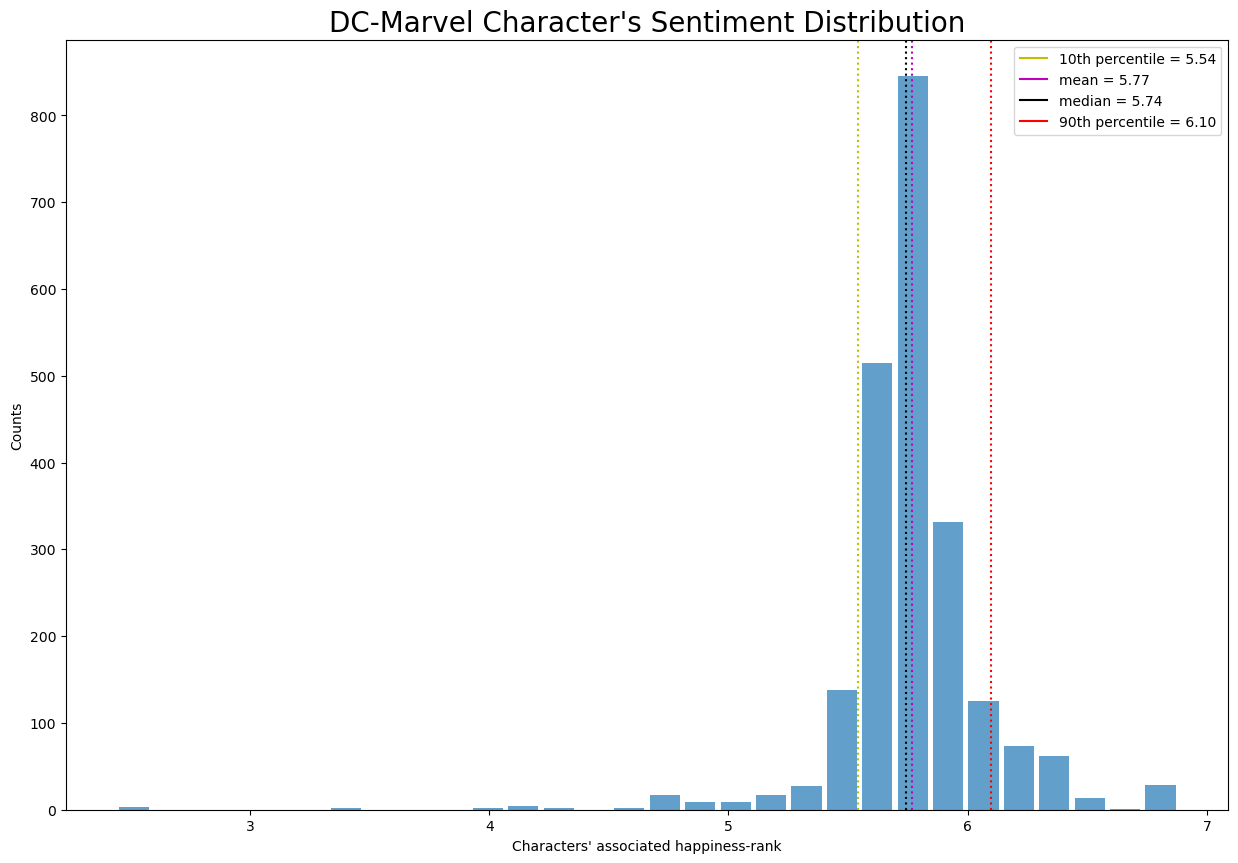

In [10]:
def plot_sentiment(dictionary, title):
    fig, ax = plt.subplots(figsize = (15,10))
    
    num_of_bins = 30
    counts , edges = np.histogram(list(dictionary.values()),bins=num_of_bins)
    
    max_count = np.max(counts)
    spc = list(dictionary.values())
    plt.hist(spc, bins = num_of_bins, alpha=0.7, rwidth=0.85)

    # Calculate percentiles
    percentile_10, median, mean, percentile_90 = np.percentile(spc,10),np.percentile(spc,50),np.mean(spc), np.percentile(spc,90)

    # [percentile, colour]
    percentiles = [[percentile_10, "y"], [mean, "m"], [median, "k"],  [percentile_90, "r"]]

    # Plot the lines with a loop
    for i in percentiles:
        ax.axvline(i[0], color=i[1], linestyle = ":")

    legends = [Line2D([0], [0], marker=None, color=percentiles[0][1], label= f"10th percentile = {percentiles[0][0]:.2f}"),
               Line2D([0], [0], marker=None, color=percentiles[1][1], label= f"mean = {percentiles[1][0]:.2f}"),
               Line2D([0], [0], marker=None, color=percentiles[2][1], label= f"median = {percentiles[2][0]:.2f}"),
               Line2D([0], [0], marker=None, color=percentiles[3][1], label= f"90th percentile = {percentiles[3][0]:.2f}")]

    ax.set_xlabel("Characters' associated happiness-rank")
    ax.set_ylabel("Counts")
    
    plt.title(title, size=20)
    plt.legend(handles = legends, loc=1, fontsize = 10)
    plt.show()
    return mean

average_of_all = plot_sentiment(sentiment_per_character, "DC-Marvel Character's Sentiment Distribution")
               

As expected most of the characters's associated pages fall very close to 5 which the median of the happiness ranking with a small right skew. The distribution is not centered in 5 but in 5.7-5.8 where both the median and average fall into. We can see also that the 10th percentile is also located above 5 whereas the 90th one is located a little above 6. Therefore 80% of our characters's pages are ranked between 5.54 and 6.1 and we can see a few big outliers in the lower rank that reach even the 2 happiness-rank whereas in the right side the maximum value is below 7 (happiness rank ranges from 1 to 9).

In [12]:
good_bad = pd.read_table("../Data/good_bad.txt", delimiter=",")

#create a dictionary with key the CharacterName and value = 10 if good, 1 if bad, 0 if neutral
char_mapping = {"good":10, "bad":1, "neutral":0}
good_bad_dictionary = dict(zip(good_bad["CharacterName"], good_bad["good"]*10+good_bad["bad"]))

In [13]:
#compute happiness-rank or sentiment only for good characters
sentiment_per_good_character = {characterName: sentiment for characterName, sentiment 
                                in sentiment_per_character.items() 
                                if good_bad_dictionary[characterName] == char_mapping["good"]}

#compute happiness-rank or sentiment only for bad characters
sentiment_per_bad_character = {characterName: sentiment for characterName, sentiment 
                                in sentiment_per_character.items() 
                                if good_bad_dictionary[characterName] == char_mapping["bad"]}

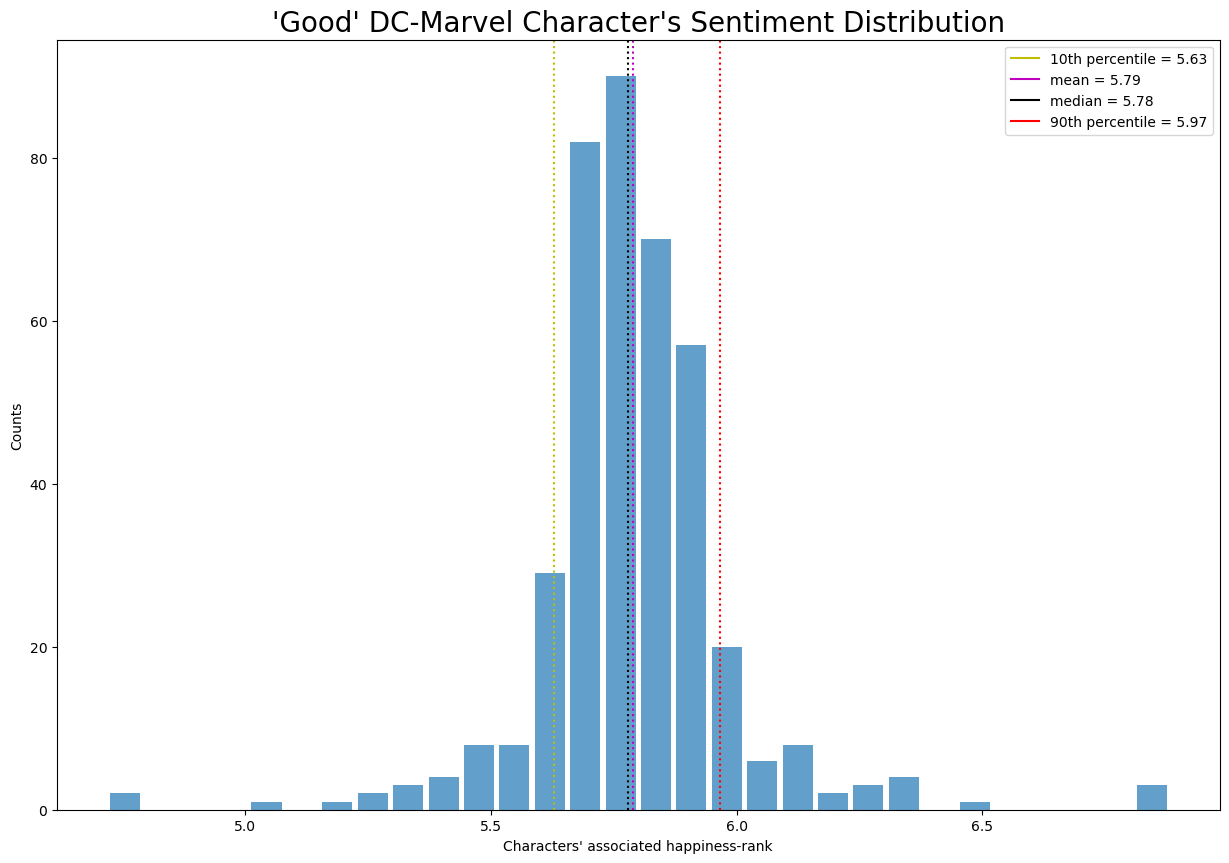

In [14]:
average_of_good = plot_sentiment(sentiment_per_good_character,
                                 "'Good' DC-Marvel Character's Sentiment Distribution")

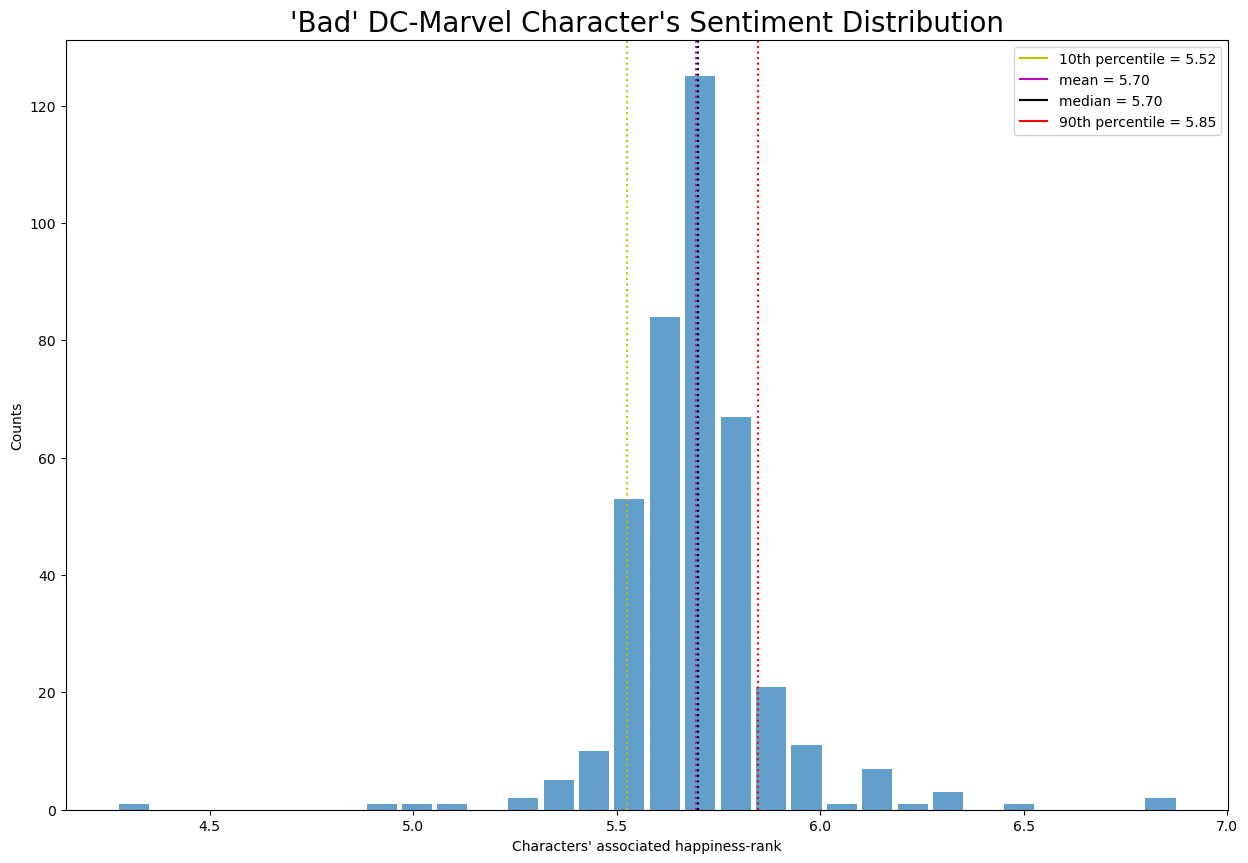

In [15]:
average_of_bad = plot_sentiment(sentiment_per_bad_character,
                               "'Bad' DC-Marvel Character's Sentiment Distribution")

Finally use the label permutation test to investigate the two hypotheses below
* H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

In [16]:
print(f"Average sentiment of all characters: {average_of_all:.2f}")
print(f"Average sentiment of good characters: {average_of_good:.2f}")
print(f"Average sentiment of bad characters: {average_of_bad:.2f}")
print(f"Number of all characters = {len(sentiment_per_character)}")
print(f"Number of good characters = {len(sentiment_per_good_character)}")
print(f"Number of bad characters = {len(sentiment_per_bad_character)}")

Average sentiment of all characters: 5.77
Average sentiment of good characters: 5.79
Average sentiment of bad characters: 5.70
Number of all characters = 2228
Number of good characters = 404
Number of bad characters = 397


Just from the averages we can see that there is an indication that the hypotheses H1 and H2 are true, even though the difference is not high which is expected since the texts are retrieved from wikipedia pages where the tone of the text is generally neutral.
But let's try to convert our intuition to a statistical proof.

#### H1: Good characters have a higher average value for sentiment than a similarly sized set of randomly selected characters.

Let's make a null hypothesis as follows:
* H0: Good characters do **NOT** have a higher average value for sentiment than a similarly sized set of randomly selected characters.

We are going to create 10,000 random samples of 404 characters which is the number of good characters provided by the list and extract their average happiness-rank.
Afterwards we are going to compute the *p-value* which is the percentage of these 10,000 average happiness-ranks that are larger or equal to the average happiness-rank of the good characters computed above.
In this way we will know which is the probability of randomly selected characters to have a higher happiness-rank than the ones that we know that they are the good ones. Of course, if this probability is high then we can probably say that whether the character is good or bad has nothing to do with the happiness-rank of his/her wiki page and therefore not reject the null hypothesis. In contrast, if this probability is low (we are going to define this via the significance level) this means that we can reject the null hypothesis and accept the **H1** hypothesis stated in the assignment.
Finally, we have to set a specific threshold for the value of the *p-value* under which we will consider the null-hypothesis rejected. This is called significance level in the literature and usually the greek alpha is used to symbolize it. We are going to set the significance level for our case to $\alpha = 5\%$.

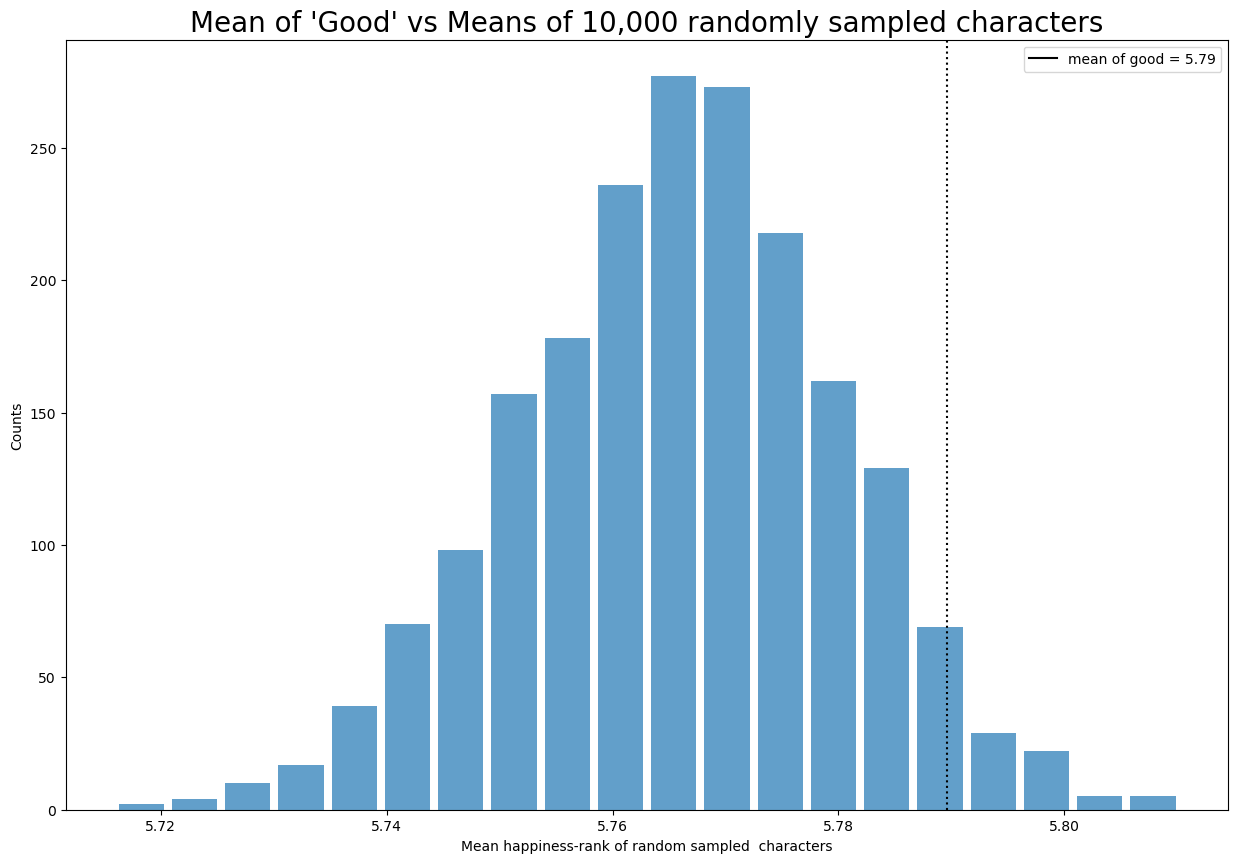

p-value = 3.85%


In [17]:
mean_sentiment_of_random_characters = []
good_characters_number = len(sentiment_per_good_character)
characters = list(sentiment_per_character.keys())
for i in range(2000):
    # get we need same size as the good characters so we ll get the first G characters
    # where G is the number of good characters
    random_characters = np.random.permutation(characters)[:good_characters_number]
    average = sum(sentiment_per_character[char] for char in random_characters)/good_characters_number
    mean_sentiment_of_random_characters.append(average)
    

# plot 
fig, ax = plt.subplots(figsize = (15,10))
plt.hist(mean_sentiment_of_random_characters, bins = 20, alpha=0.7, rwidth=0.85)
ax.axvline(average_of_good, color="k", linestyle = ":")
legends = [Line2D([0], [0], marker=None, color="k", label= f"mean of good = {average_of_good:.2f}")]
ax.set_xlabel("Mean happiness-rank of random sampled  characters")
ax.set_ylabel("Counts")
plt.title("Mean of 'Good' vs Means of 10,000 randomly sampled characters", size=20)
plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()

p_value = len([x for x in mean_sentiment_of_random_characters if x >= average_of_good])/len(mean_sentiment_of_random_characters)

print(f"p-value = {p_value*100:.2f}%")

From the plot we can see that the random mean happiness rank of the 10,000 random samples follows an almost perfect normal distribution. The average happiness-rank of the 'good' characters falls in the right part of this distribution with the p-value=3.85%, therefore only 3.85% of the samples had equal or higher happiness-rank than our 'good' characters. Since we set our significance level to 5% and $p-value < \alpha$, we can **reject the null hypothesis** and conclude that the **H1 hypothesis is true**. So, Good characters have a higher average value for sentiment than a similarly sized set of randomly selected characters. 

#### H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

We are going to follow the same approach for bad characters.

Let's make a null hypothesis as follows whereas the significance level will be the same as defined above:
* H0: Bad characters do **NOT** have a lower average value for sentiment than a similarly sized set of randomly selected characters.

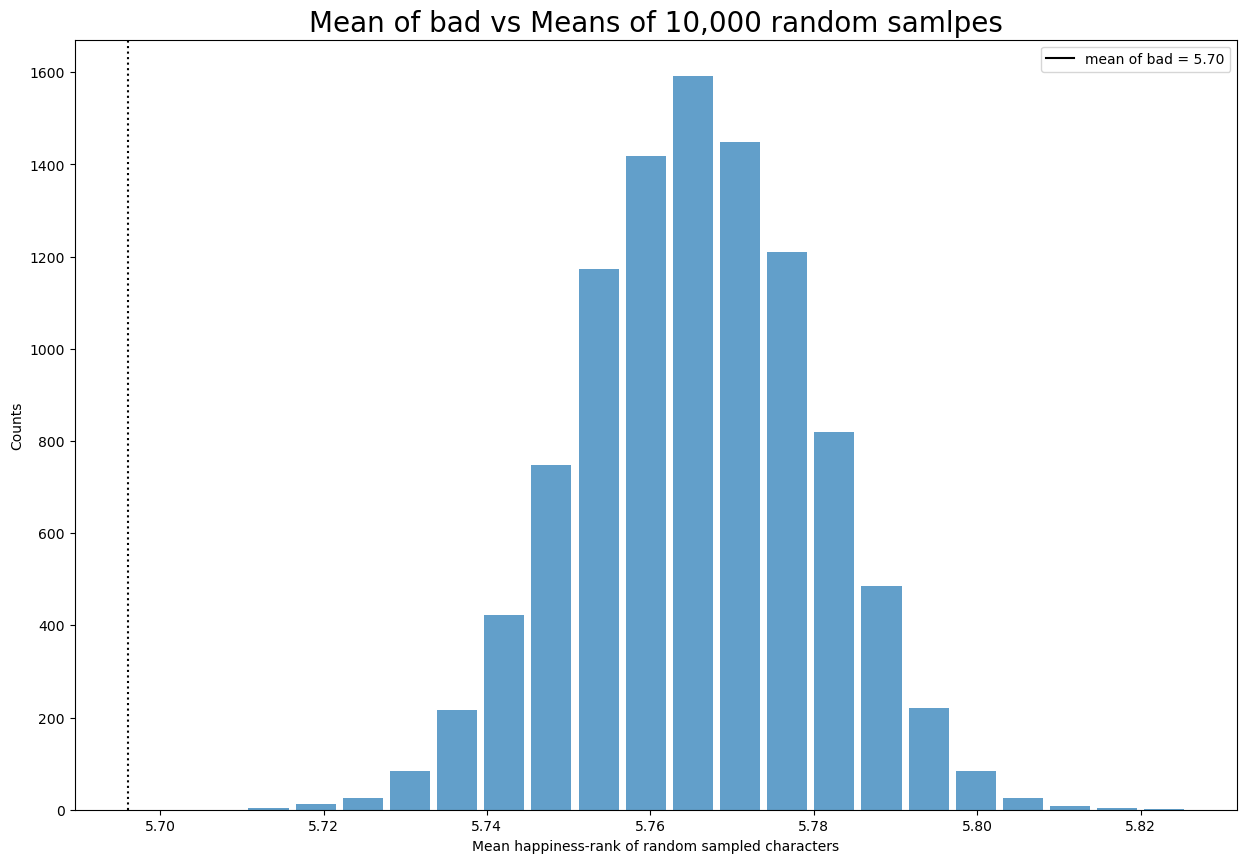

p-value = 0.00%


In [18]:
mean_sentiment_of_random_characters = []
bad_characters_number = len(sentiment_per_bad_character)
characters = list(sentiment_per_character.keys())
for i in range(10000):
    # get we need same size as the good characters so we ll get the first G characters
    # where G is the number of good characters
    random_characters = np.random.permutation(characters)[:bad_characters_number]
    average = sum(sentiment_per_character[char] for char in random_characters)/bad_characters_number
    mean_sentiment_of_random_characters.append(average)

    
    
    
fig, ax = plt.subplots(figsize = (15,10))
plt.hist(mean_sentiment_of_random_characters, bins = 20, alpha=0.7, rwidth=0.85)
ax.axvline(average_of_bad, color="k", linestyle = ":")
legends = [Line2D([0], [0], marker=None, color="k", label= f"mean of bad = {average_of_bad:.2f}")]
ax.set_xlabel("Mean happiness-rank of random sampled characters")
ax.set_ylabel("Counts")
plt.title("Mean of bad vs Means of 10,000 random samlpes", size=20)
plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()


p_value = len([x for x in mean_sentiment_of_random_characters if x <= average_of_bad])/len(mean_sentiment_of_random_characters)

print(f"p-value = {p_value*100:.2f}%")



In this case we have similar results but the p-value is 0% which makes us even more confident for rejecting the null hypothesis and accepting the **H2** hypothesis. Therefore we can say that yes the Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.